# 测试
1. 4个训练客户端，简单模拟 https://www.bilibili.com/opus/652063571270696963 

In [3]:
from ray.rllib.algorithms.ppo import PPOConfig
import sys
sys.path.append(r"..")
from easy_helper import simplify_rllib_metrics
from compress import GradientCompressor, ParamCompressor
from ray.rllib.algorithms.ppo.torch.ppo_torch_learner import PPOTorchLearner
from ray.rllib.core import COMPONENT_RL_MODULE
import copy
import gymnasium as gym
import pandas as pd
import time
from collections import OrderedDict
from tqdm import tqdm

# 参数设置

In [4]:
allow_delay = 4# 每4个minibatch需要强制同步最新参数
# params_compress = True# 是否压缩参数
params_compress = False# 是否压缩参数
# grad_compress = True# 是否压缩梯度
grad_compress = False# 是否压缩梯度

# 模拟参数服务器训练(3个训练客户端)

In [5]:

server = None
pc = None
gc = None

def get_weights(learner):
    return learner.get_state(components=COMPONENT_RL_MODULE)['rl_module']['default_policy']

def apply_gradients(gradients_list, learner):
    """更新参数"""
    # 解压梯度
    if params_compress:
        gradients_list, compress_info = gradients_list
        gradients_list = pc.decompress(gradients_list, compress_info)

    # 应用梯度
    params = learner._params
    for k, v in zip(list(params.keys()), gradients_list):
        params[k].grad = v.to(learner._device)
    learner.apply_gradients({})
    weights = get_weights(learner)

    # 压缩参数
    if params_compress:
        weights = pc.compress_params_dict(weights)

    return weights

class DebugLearner(PPOTorchLearner):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.server_weights = None
        self.count = 0

    def apply_gradients(self, gradients_dict) -> None:
        # 无用更新，最终参数也会被覆盖，可以优化
        # 客户端只需要计算梯度，不需要更新参数
        # super().apply_gradients(gradients_dict)

        # 每 allow_delay 个minibatch同步一次参数
        self.count += 1
        if allow_delay<=1 or self.count % allow_delay == 0:
            # 解压参数
            if params_compress:
                compressed_list, info_list = self.server_weights
                self.server_weights = pc.decompress_params_dict(compressed_list, info_list)

            self.set_state({'rl_module': {'default_policy': self.server_weights}})
    
    def compute_gradients(self, loss_per_module, **kwargs):
        gradients = super().compute_gradients(loss_per_module, **kwargs)

        # 统一成梯度列表
        gradients = [grad.to('cpu') for grad in gradients.values()]
        # 压缩梯度
        if grad_compress:
            gradients = gc.compress(gradients)

        # 1. 梯度传递给参数服务器, 获取服务器参数
        self.server_weights = apply_gradients(gradients, server)

        return {}

server_config = (
    PPOConfig()
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .env_runners(num_env_runners=0)
)

client_config = (
    PPOConfig()
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .api_stack(
        enable_rl_module_and_learner=True,
        enable_env_runner_and_connector_v2=True,
    )
    .environment("CartPole-v1")
    .env_runners(num_env_runners=0)
    .training(
        learner_class=DebugLearner,# 调试学习者
    )
)

# 多次取平均
all_mean_returns = []
for j in range(10):
    # 初始化 参数服务器
    server = server_config.build_learner(env=gym.make("CartPole-v1"))
    server.build()

    # 初始化 客户端
    clients = []
    for i in range(3):
        clients.append(client_config.build())

    # 同步服务器参数 > 客户端
    server_init_params = get_weights(server)
    server_init_params = {'default_policy': server_init_params}
    for client in clients:
        client.learner_group.set_weights(server_init_params)

    mean_returns = []
    for i in tqdm(range(30), desc=f"[{j}]"):
        for idx, client in enumerate(clients):
            res = client.train()
            if idx == 0:
                result = simplify_rllib_metrics(res, out_func=lambda x: None)
                mean_returns.append(result["环境运行器"]["episode平均回报"])

    all_mean_returns.append(mean_returns)

2025-01-30 19:08:28,875	WARNING rl_module.py:427 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. Some algos already use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.
2025-01-30 19:08:29,181	WARNING ppo.py:295 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
d:\programs\miniconda3\Lib\site-packages\ray\rllib\algorithms\algorithm.py:569: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You

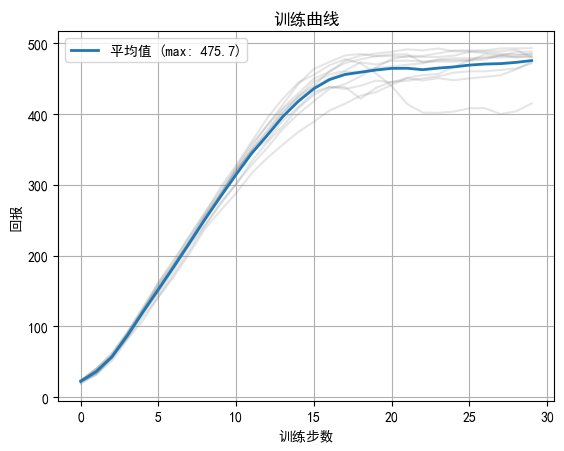

In [6]:
# 可视化
data = pd.DataFrame()
for idx, _data in enumerate(all_mean_returns):
    data[f"轮次{idx}"] = _data

data['mean'] = data.mean(axis=1)

import matplotlib.pyplot as plt
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 绘制所有轮次的曲线(淡显)
for col in data.columns:
    if col != 'mean':
        plt.plot(data[col], alpha=0.2, color='gray')

# 绘制平均值曲线(实线)        
max_val = data['mean'].max()
plt.plot(data['mean'], linewidth=2, label=f'平均值 (max: {max_val:.1f})')

plt.xlabel('训练步数')
plt.ylabel('回报')
plt.title('训练曲线')
plt.legend()
plt.grid(True)
plt.show()